In [1]:
from cppredictor import build_conformal_predictor
from cppredictor import coco_label_from_index
from detectron2.config import get_cfg
from detectron2 import model_zoo
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [10]:
# Configure Detectron Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.6 # set IoU threshold
cfg.MODEL.DEVICE = 'cuda'  # 명시적으로 GPU 사용 지정

predictor = build_conformal_predictor(cfg)

test_img_path = "input.jpg"
test_img = cv2.imread(test_img_path)  # → numpy.ndarray


outputs = predictor(test_img)

Using device: cuda
ConformalPredictor initialized with hooks


In [3]:
print(len(outputs["instances"].pred_classes))
pred_classes = coco_label_from_index(outputs["instances"].pred_classes)
print(pred_classes)

16
['horse', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'umbrella', 'person', 'umbrella', 'umbrella', 'person', 'person', 'person', 'backpack']


In [4]:
'''
#무엇과 무엇이 같아야 하는가? argmax probs 와 pred_classes가 같아야 함 테스트
print(outputs["instances"].pred_classes[0])
print(outputs["instances"].class_probs[0])
test_idx = outputs["instances"].class_probs[0].cpu().numpy()
print(np.argmax(test_idx))
'''

'\n#무엇과 무엇이 같아야 하는가? argmax probs 와 pred_classes가 같아야 함 테스트\nprint(outputs["instances"].pred_classes[0])\nprint(outputs["instances"].class_probs[0])\ntest_idx = outputs["instances"].class_probs[0].cpu().numpy()\nprint(np.argmax(test_idx))\n'

In [5]:
'''
pred_classes = outputs["instances"].pred_classes  # shape: [num_instances]
pred_label = coco_label_from_index(pred_classes)
print(pred_label)
print(outputs["instances"].class_probs[0])
print(outputs["instances"].scores[0])
test_idx = outputs["instances"].class_probs[0].cpu().numpy()
print(test_idx)
print(np.argmax(test_idx))'
'''

'\npred_classes = outputs["instances"].pred_classes  # shape: [num_instances]\npred_label = coco_label_from_index(pred_classes)\nprint(pred_label)\nprint(outputs["instances"].class_probs[0])\nprint(outputs["instances"].scores[0])\ntest_idx = outputs["instances"].class_probs[0].cpu().numpy()\nprint(test_idx)\nprint(np.argmax(test_idx))\'\n'

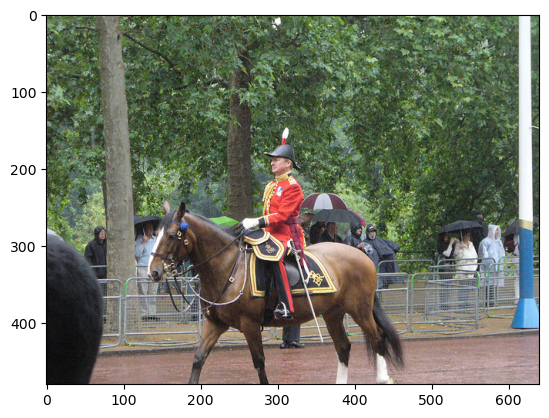

In [4]:
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(test_img)

In [5]:
### Get quantiles for split conformal prediction
print(outputs["instances"].pred_classes)
#output_classes = coco_label_from_index(conformal_out["instances"].pred_classes.item())
for i in range(len(outputs["instances"].pred_classes)):
  print(f"{i} : {outputs['instances'].pred_classes[i]} : {coco_label_from_index(outputs['instances'].pred_classes[i])}")

instances = outputs["instances"].to("cpu")
pred_classes = instances.pred_classes.numpy()
scores = instances.scores.numpy()
nonconformity_score = 1 - scores

tensor([17,  0,  0,  0,  0,  0,  0,  0, 25,  0, 25, 25,  0,  0,  0, 24],
       device='cuda:0')
0 : 17 : horse
1 : 0 : person
2 : 0 : person
3 : 0 : person
4 : 0 : person
5 : 0 : person
6 : 0 : person
7 : 0 : person
8 : 25 : umbrella
9 : 0 : person
10 : 25 : umbrella
11 : 25 : umbrella
12 : 0 : person
13 : 0 : person
14 : 0 : person
15 : 24 : backpack


In [6]:
from detectron2.utils.visualizer import GenericMask
from detectron2.structures import BoxMode
from detectron2.data.datasets import load_coco_json
from detectron2.structures import BoxMode

def compute_iou(boxA, boxB):
    # standard IoU function
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return interArea / float(boxAArea + boxBArea - interArea)

In [7]:
image_root = "/home/datasets/coco/val2017"
json_file = "/home/datasets/coco/annotations/instances_val2017.json"

val_dataset_dicts = load_coco_json(json_file, image_root, dataset_name="coco_val2017")

In [11]:
calibration_scores = [] # calibration dataset의 score. adaptive set이 아님
cnt = 0

for data in val_dataset_dicts:
    if cnt % 500 == 0:
        print(f"processing data is : {data["file_name"]}, iter : {cnt}")
    cnt += 1
    
    img = cv2.imread(data["file_name"])
    outputs = predictor(img)

    pred_boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()
    pred_scores = outputs["instances"].scores.cpu().numpy()
    pred_classes = outputs["instances"].pred_classes.cpu().numpy()

    gt_boxes = [BoxMode.convert(ann["bbox"], BoxMode.XYWH_ABS, BoxMode.XYXY_ABS) for ann in data["annotations"]]
    gt_classes = [ann["category_id"] for ann in data["annotations"]]

    matched_gt = set()  # 이미 매칭된 ground truth box의 인덱스
    for i, gt_box in enumerate(gt_boxes):
        best_iou = 0
        best_idx = -1
        for j, pred_box in enumerate(pred_boxes):
            if j in matched_gt:
                continue
            iou = compute_iou(gt_box, pred_box)
            if iou >= 0.5 and iou > best_iou:
                best_iou = iou
                best_idx = j
        if best_idx != -1:
            matched_gt.add(best_idx)
            score = pred_scores[best_idx]
            # Non-conformity score = 1 - P(y | x)
            calibration_scores.append(1 - score)

processing data is : /home/datasets/coco/val2017/000000000139.jpg, iter : 0
processing data is : /home/datasets/coco/val2017/000000057027.jpg, iter : 500
processing data is : /home/datasets/coco/val2017/000000119365.jpg, iter : 1000
processing data is : /home/datasets/coco/val2017/000000173091.jpg, iter : 1500
processing data is : /home/datasets/coco/val2017/000000229753.jpg, iter : 2000
processing data is : /home/datasets/coco/val2017/000000289594.jpg, iter : 2500
processing data is : /home/datasets/coco/val2017/000000347544.jpg, iter : 3000
processing data is : /home/datasets/coco/val2017/000000405249.jpg, iter : 3500
processing data is : /home/datasets/coco/val2017/000000463174.jpg, iter : 4000
processing data is : /home/datasets/coco/val2017/000000521601.jpg, iter : 4500


In [11]:
print(len(calibration_scores))
calibration_scores = np.array(calibration_scores)
print(calibration_scores.shape)
print(calibration_scores[:-10])

sorted_score = np.sort(calibration_scores)
alpha = 0.05
n = len(sorted_score)
quantile_index = int(np.ceil((1 - alpha) * (n + 1))) - 1 # 0-based index

#quantile_index = int(np.ceil((n + 1) * (1 - alpha)/n))
q_hat = sorted_score[quantile_index]
print(f"q_hat: {q_hat}, n = {n}, quantile_index = {quantile_index}")
print(sorted_score[:10], n, quantile_index, q_hat)

24494
(24494,)
[0.00593388 0.07969689 0.02523732 ... 0.16428697 0.00428975 0.10539466]
q_hat: 0.43389320373535156, n = 24494, quantile_index = 23270
[6.19888306e-05 7.03334808e-05 8.04662704e-05 8.78572464e-05
 9.64403152e-05 9.91821289e-05 1.05381012e-04 1.09076500e-04
 1.18613243e-04 1.19447708e-04] 24494 23270 0.43389320373535156


In [12]:
# COCO validation 이미지 루트와 annotation 경로
test_image_root = "/home/datasets/coco/val2017"
test_json_file = "/home/datasets/coco/annotations/instances_val2017.json"

# validation dataset 중 하나 불러오기
test_dataset_dicts = load_coco_json(test_json_file, test_image_root, dataset_name="coco_val2017")

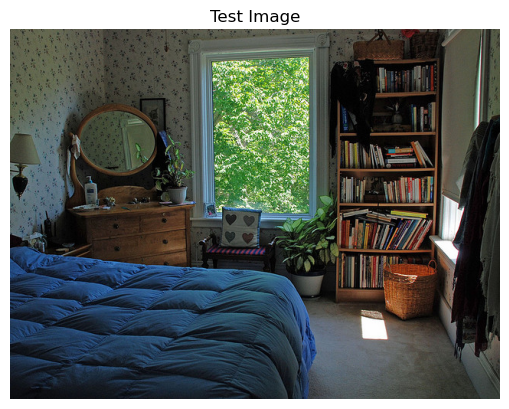

In [13]:
test_sample = test_dataset_dicts[2]

# 이미지 로드 및 출력
image_path = test_sample["file_name"]
test_image = cv2.imread(image_path)
test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

plt.imshow(test_image_rgb)
plt.title("Test Image")
plt.axis("off")
plt.show()

In [14]:
conformal_out = predictor(test_image)
# 예측 결과
#print(conformal_out["instances"])
#print(conformal_out["instances"].scores)
print(conformal_out["instances"].pred_classes)
#output_classes = coco_label_from_index(conformal_out["instances"].pred_classes.item())
for i in range(len(conformal_out["instances"].pred_classes)):
  print(f"{i} : {conformal_out['instances'].pred_classes[i]} : {coco_label_from_index(conformal_out['instances'].pred_classes[i])}")

instances = conformal_out["instances"].to("cpu")
pred_classes = instances.pred_classes.numpy()
scores = instances.scores.numpy()
nonconformity_score = 1 - scores


tensor([58, 56, 59, 58, 39, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73,
        73, 73, 73, 73, 73, 73, 73, 73, 73], device='cuda:0')
0 : 58 : potted plant
1 : 56 : chair
2 : 59 : bed
3 : 58 : potted plant
4 : 39 : bottle
5 : 73 : book
6 : 73 : book
7 : 73 : book
8 : 73 : book
9 : 73 : book
10 : 73 : book
11 : 73 : book
12 : 73 : book
13 : 73 : book
14 : 73 : book
15 : 73 : book
16 : 73 : book
17 : 73 : book
18 : 73 : book
19 : 73 : book
20 : 73 : book
21 : 73 : book
22 : 73 : book
23 : 73 : book
24 : 73 : book
25 : 73 : book
26 : 73 : book


In [15]:
print(conformal_out["instances"].class_probs[2])

conf_thr = 1-q_hat
print(f"conf_thr: {conf_thr}")
# 마스크로 q_hat을 넘지 않는 클래스를 제거
mask = conformal_out["instances"].class_probs >= q_hat
print(mask[0])


tensor([4.0278e-05, 3.1515e-08, 3.0319e-05, 7.9018e-08, 3.9636e-06, 2.1637e-07,
        7.7257e-06, 1.4912e-06, 9.1257e-06, 1.0609e-08, 3.2790e-08, 4.1680e-08,
        3.3854e-08, 4.2729e-06, 5.4662e-07, 3.5311e-06, 1.1674e-05, 2.5290e-07,
        5.6214e-07, 1.0452e-06, 2.4837e-06, 6.3486e-07, 5.5398e-07, 2.3291e-07,
        2.3163e-06, 9.2962e-06, 6.8113e-07, 7.2451e-07, 1.2433e-05, 5.2484e-08,
        2.7976e-07, 1.2182e-07, 7.2474e-08, 1.3052e-06, 2.2335e-08, 1.3428e-08,
        1.3901e-08, 1.9584e-06, 8.1993e-09, 9.4038e-09, 8.7070e-09, 1.7756e-09,
        1.6981e-08, 1.8213e-08, 1.1730e-08, 8.8532e-08, 6.4274e-08, 2.5921e-08,
        9.8431e-08, 4.6170e-08, 3.8002e-09, 2.5335e-08, 4.1787e-08, 1.2674e-06,
        2.0037e-07, 2.8020e-06, 1.7074e-05, 1.8810e-03, 9.9029e-08, 9.9006e-01,
        2.1624e-05, 5.4750e-07, 5.1673e-06, 5.4716e-07, 6.8041e-08, 1.2606e-07,
        3.4182e-07, 2.6344e-08, 1.1925e-07, 4.6033e-07, 1.8914e-07, 4.0937e-06,
        1.2112e-06, 1.2591e-06, 2.7988e-

In [16]:
pred_sets = [torch.where(mask[i])[0].tolist() for i in range(mask.shape[0])]
print(pred_sets, len(pred_sets))
print(coco_label_from_index(pred_sets[0]))


[[58], [56], [59], [58], [39], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73], [73, 80], [73, 80], [73, 80], [73, 80], [73, 80], [73, 80], [73, 80], [73, 80], [73, 80], [73, 80], [73, 80]] 27
['potted plant']


In [17]:
pred_labels = [coco_label_from_index(pset) for pset in pred_sets]
print(pred_labels, len(pred_labels))

[['potted plant'], ['chair'], ['bed'], ['potted plant'], ['bottle'], ['book'], ['book'], ['book'], ['book'], ['book'], ['book'], ['book'], ['book'], ['book'], ['book'], ['book'], ['book', 'background'], ['book', 'background'], ['book', 'background'], ['book', 'background'], ['book', 'background'], ['book', 'background'], ['book', 'background'], ['book', 'background'], ['book', 'background'], ['book', 'background'], ['book', 'background']] 27


In [18]:
print(conformal_out["instances"].pred_classes , len(conformal_out["instances"].pred_classes))
print(conformal_out["instances"].class_probs[26])
print(conformal_out["instances"].class_probs.shape)

tensor([58, 56, 59, 58, 39, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73,
        73, 73, 73, 73, 73, 73, 73, 73, 73], device='cuda:0') 27
tensor([3.1375e-06, 1.4154e-07, 6.2485e-07, 5.0345e-08, 9.6824e-08, 1.8379e-07,
        5.7962e-08, 6.3655e-07, 1.6499e-07, 1.2368e-07, 4.6864e-08, 9.4982e-08,
        1.1970e-07, 7.9278e-07, 1.9361e-07, 1.1531e-07, 9.0505e-08, 1.2779e-08,
        4.7520e-08, 1.0795e-08, 3.9836e-08, 5.1447e-08, 8.2160e-08, 6.1948e-08,
        2.6878e-07, 7.4685e-07, 1.0976e-06, 1.4537e-06, 7.6429e-07, 8.2956e-08,
        1.2707e-06, 2.5093e-07, 4.1377e-08, 4.7209e-08, 8.1604e-07, 3.9232e-08,
        9.2779e-07, 1.0998e-06, 1.8329e-07, 4.5962e-05, 1.2947e-07, 2.6063e-06,
        9.1341e-07, 1.0354e-05, 1.0879e-06, 4.3624e-07, 3.6254e-07, 5.6180e-08,
        3.9615e-07, 2.7581e-08, 1.7223e-07, 1.5118e-07, 5.4522e-07, 1.9458e-07,
        9.5296e-08, 1.5327e-07, 5.8719e-06, 1.9922e-07, 3.4715e-07, 3.3142e-07,
        1.5522e-06, 1.4363e-07, 5.6442e-06, 4.1272e-06,

In [19]:
print(conformal_out["instances"])

Instances(num_instances=27, image_height=483, image_width=640, fields=[pred_boxes: Boxes(tensor([[341.7245, 214.9833, 433.5783, 351.1006],
        [246.9921, 230.3875, 351.2469, 319.8356],
        [  0.0000, 279.4296, 402.8839, 478.6743],
        [186.9029, 132.4222, 240.7118, 227.6362],
        [ 95.9333, 191.7592, 114.0795, 230.4717],
        [428.6659, 239.5435, 551.7964, 291.7276],
        [516.7791,  53.7417, 521.6321,  82.0529],
        [523.3776, 144.7887, 553.4017, 180.7844],
        [476.9078, 152.5103, 489.4576, 181.0081],
        [469.9594, 150.5757, 478.2147, 182.2627],
        [461.9326, 253.7417, 469.3803, 286.2030],
        [462.7222,  41.2429, 557.2936,  83.4607],
        [491.5431, 169.0197, 529.7000, 175.1155],
        [491.3108, 249.2589, 524.0553, 288.8299],
        [444.1169, 148.7574, 449.6732, 181.8454],
        [473.9217, 254.2586, 482.4062, 286.8022],
        [480.7989, 255.3910, 495.0917, 286.6512],
        [484.7455, 255.7964, 499.2149, 286.9809],
        [47